# CS 533 Group Project
Authors: Malia Barker, Atharva Pargaonkar, Jack Cunningham, Rubal Goyal, Shrutee Dwa

## 🔷 Importing python tools and the data

In [2]:
# Import the required tools and libraries
# Numerical tools
import pandas as pd
import numpy as np
# Plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
# Machine Learning Tools, Utilities, and Scoring Metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
# Suite of Machine Learning Algorithms
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
# Setup to Ignore Version Errors and Deprecations
import warnings
warnings.filterwarnings("ignore")

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
path = "/content/drive/MyDrive/IDS Team Project/"

In [5]:
# Import the movies dataframe
movies_df = pd.read_csv(path + 'movies.csv')
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [6]:
# Import the movies dataframe
ratings_df = pd.read_csv(path + 'ratings.csv')
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 762.9 MB


In [7]:
# Import the movies dataframe
tags_df = pd.read_csv(path + 'tags.csv')
tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1093360 entries, 0 to 1093359
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   userId     1093360 non-null  int64 
 1   movieId    1093360 non-null  int64 
 2   tag        1093344 non-null  object
 3   timestamp  1093360 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 33.4+ MB


## Preprocessing

### 🔹 Merging Ratings with Tags

🔹 First, let's look at merging the ratings and the tags datasets.

In [8]:
# Combine ratings and tags on 'userId' and 'movieId' using a left join
ratings_and_tags = pd.merge(ratings_df, tags_df, on=['userId', 'movieId'], how='left')

### Helper Function

In [9]:
def get_ratings_stats(df):
    stats = df.groupby('movieId')['rating'].agg(['mean', 'median', 'min', 'max', 'std', 'var', 'count']).reset_index()
    stats['q25'] = df.groupby('movieId')['rating'].quantile(0.25).reset_index()['rating']
    stats['q50'] = df.groupby('movieId')['rating'].quantile(0.50).reset_index()['rating']
    stats['q75'] = df.groupby('movieId')['rating'].quantile(0.75).reset_index()['rating']
    stats['mode'] = df.groupby('movieId')['rating'].agg(lambda x: x.mode().iat[0]).reset_index()['rating']
    rename_cols_dict = {}
    for col in stats.columns:
        if col != 'movieId':
            new_col_name = 'ratings_' + str(col)
            rename_cols_dict[col] = new_col_name
    stats = stats.rename(columns=rename_cols_dict)
    movie_stats = pd.merge(movies_df, stats, on="movieId", how="inner")
    return movie_stats

In [10]:
# Check the dataset statistics
print(f'The ratings dataset has {ratings_df.shape[0]} total ratings')
print(f'The tags dataset has {tags_df.shape[0]} total tags')
print(f'In the ratings dataset, there are {len(ratings_df["movieId"].unique())} unique movies')
print(f"In the tags dataset, there are {len(tags_df['movieId'].unique())} unique movies")
print(f"When combining the ratings and tags datasets, there are {ratings_and_tags['tag'].isna().sum()} ratings that do not have any tags (are NaN)")

The ratings dataset has 25000095 total ratings
The tags dataset has 1093360 total tags
In the ratings dataset, there are 59047 unique movies
In the tags dataset, there are 45251 unique movies
When combining the ratings and tags datasets, there are 24789371 ratings that do not have any tags (are NaN)


There are a lot less tags than there are actual ratings, so there is a high number of null values in this dataset. Combining the tags and ratings like this, resulting in such a large number of columns and ultimately making it so the models will run very slow is probably not ideal. We will emit the ratings that do not have tags to cut down on our data size. Running models with 25 million instances is lengthy and not in scope for our project. By removing rating instances without tags, we cut our data from 25 million ratings to about a million ratings (834,730 instances, exactly).

We explore the effects of removing these instances on the overall statistics of the ratings by movie below.

## Null Value Imputation

Group by movieID to get stats by movie for three filtered datasets: all ratings, ratings with no null tags included, ratings with ONLY null tags.

In [11]:
print(f'There are {ratings_and_tags.shape[0]} total ratings.')
movies_stats_all = get_ratings_stats(ratings_and_tags)

There are 25624101 total ratings.


In [12]:
# ratings_nonull_tags = ratings_df.dropna()
ratings_nonull_tags = ratings_and_tags.dropna()
print(f'There are {ratings_nonull_tags.shape[0]} ratings that have tags.')
movies_stats_nonull = get_ratings_stats(ratings_nonull_tags)

There are 834730 ratings that have tags.


In [13]:
# ratings_null_tags = ratings_df[ratings_df['tag'].isna()]
ratings_null_tags = ratings_and_tags[ratings_and_tags['tag'].isna()]
print(f'There are {ratings_null_tags.shape[0]} ratings that do not have tags.')
movies_stats_onlynull = get_ratings_stats(ratings_null_tags)

There are 24789371 ratings that do not have tags.


In [14]:
print(f'There are {movies_stats_all.shape[0]} movies in the dataset that include ratings with BOTH null and non-null tags.')
print(f'There are {movies_stats_nonull.shape[0]} movies in the dataset that only include ratings WITH tags.')
print(f'There are {movies_stats_onlynull.shape[0]} movies in the dataset that only include ratings WITHOUT tags.')

There are 59047 movies in the dataset that include ratings with BOTH null and non-null tags.
There are 22082 movies in the dataset that only include ratings WITH tags.
There are 58292 movies in the dataset that only include ratings WITHOUT tags.


🔹 And now we want to compare the distributions of each rating statistic between the dataset with all ratings, the dataset with only ratings with null tags included, and the dataset with only ratings with null tags dropped.

In [15]:
all_cols = ['ratings_mean', 'ratings_median', 'ratings_mode', 'ratings_q25', 'ratings_q50', 'ratings_q75', 'ratings_min', 'ratings_max', 'ratings_count', 'ratings_std', 'ratings_var']

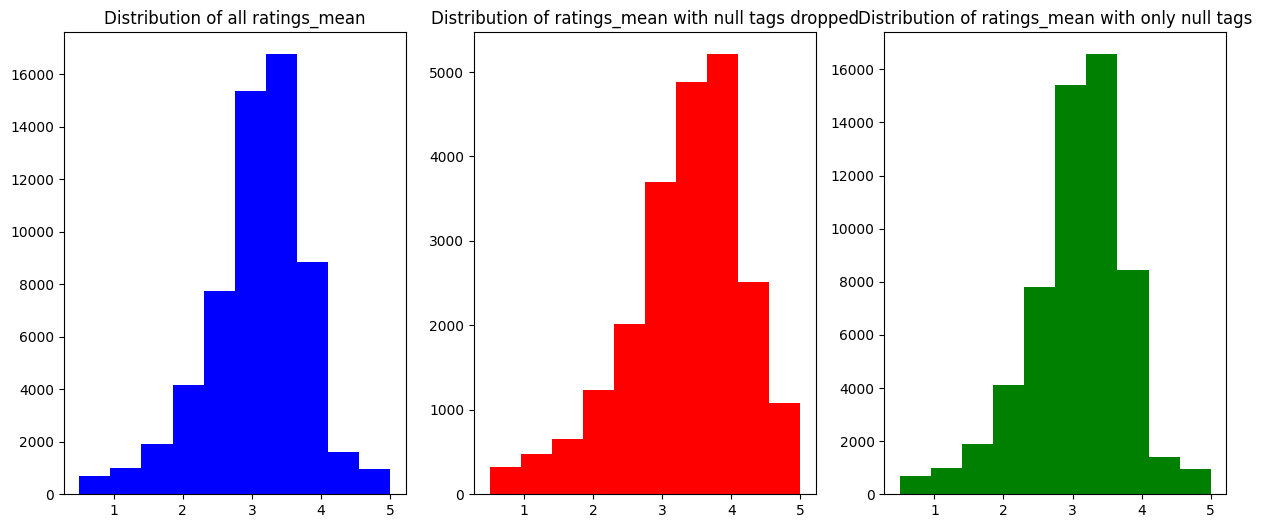

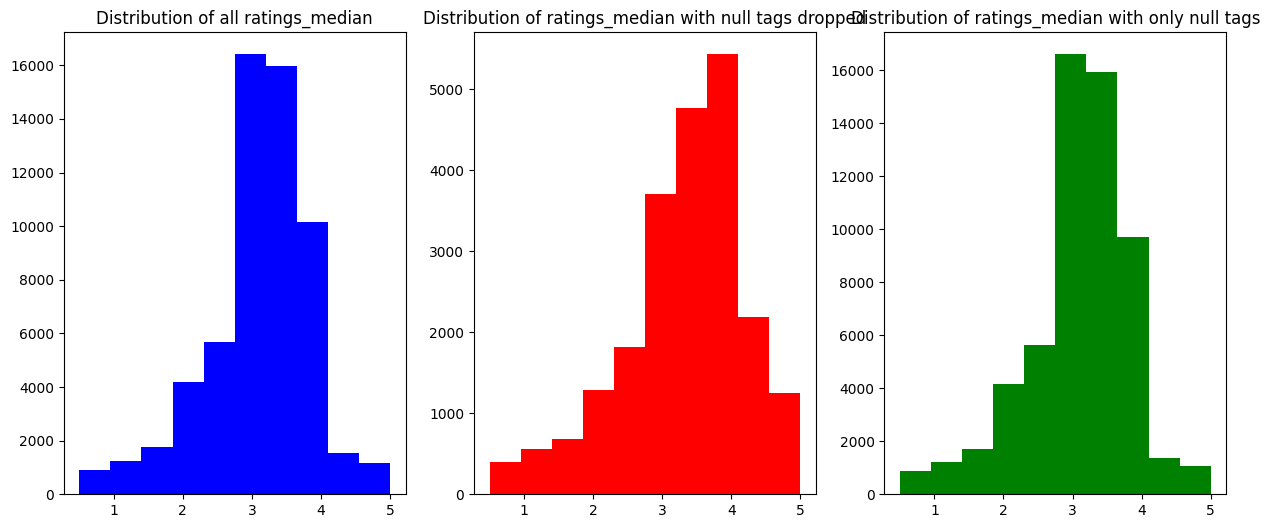

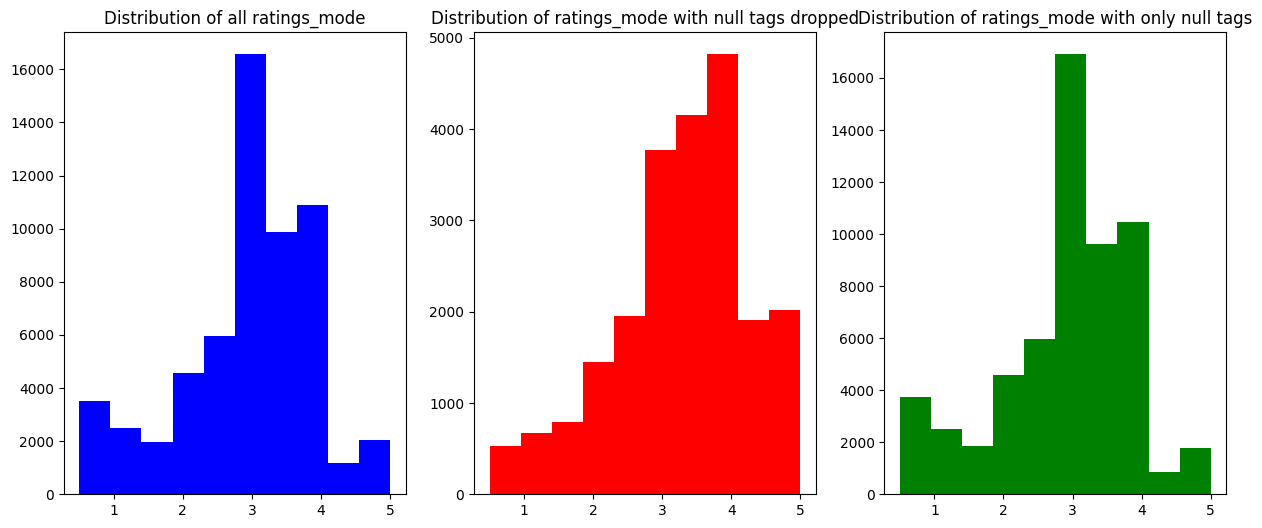

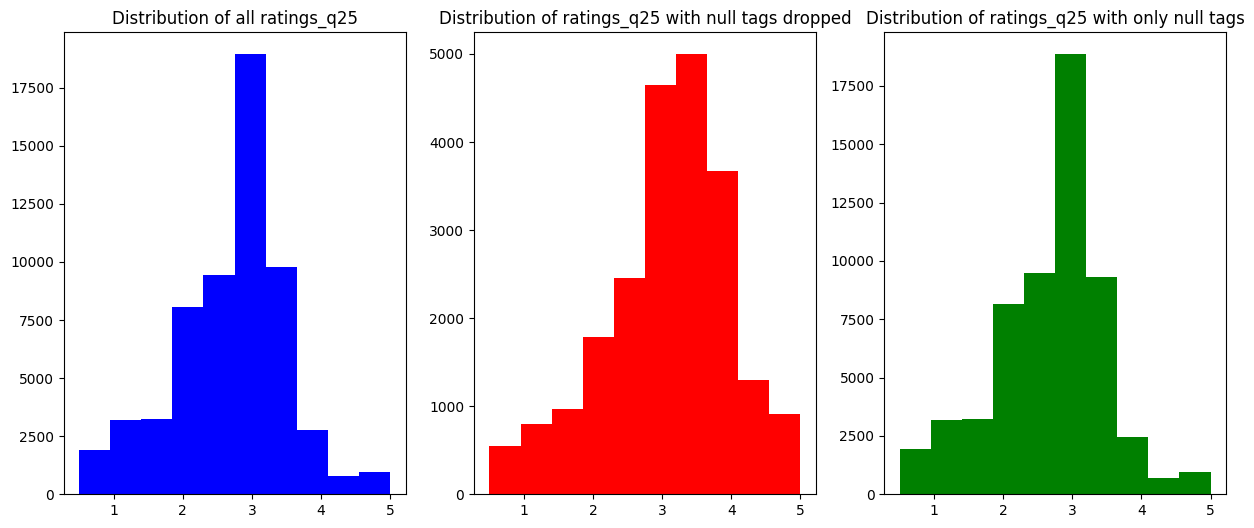

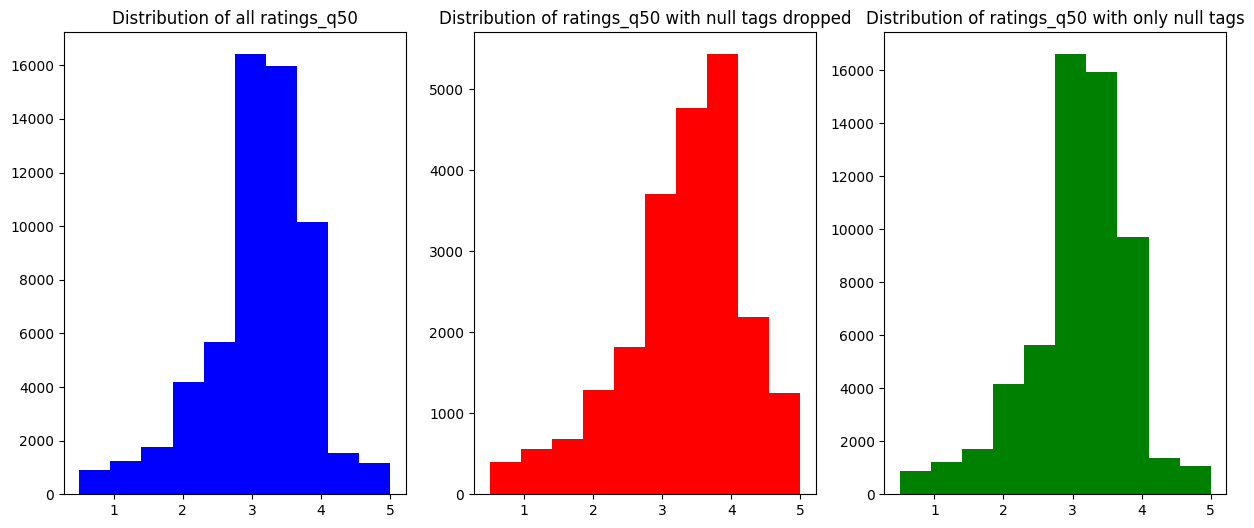

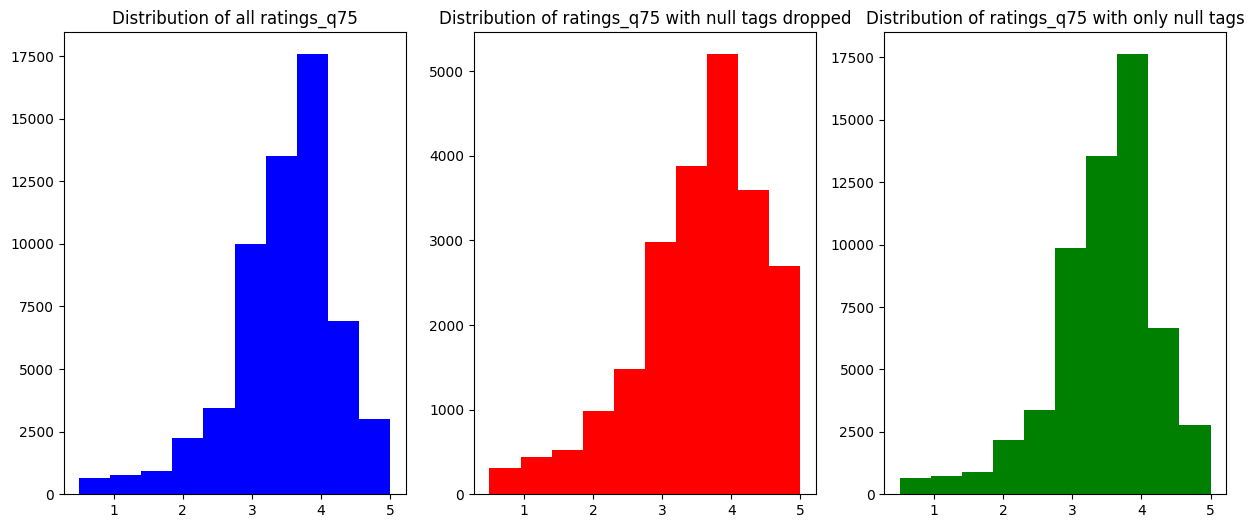

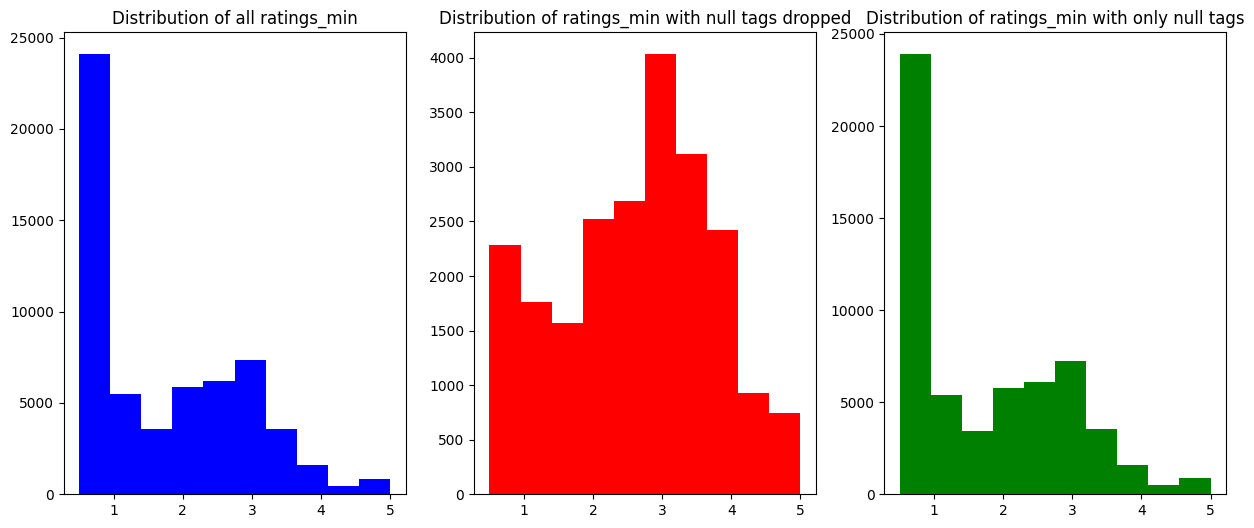

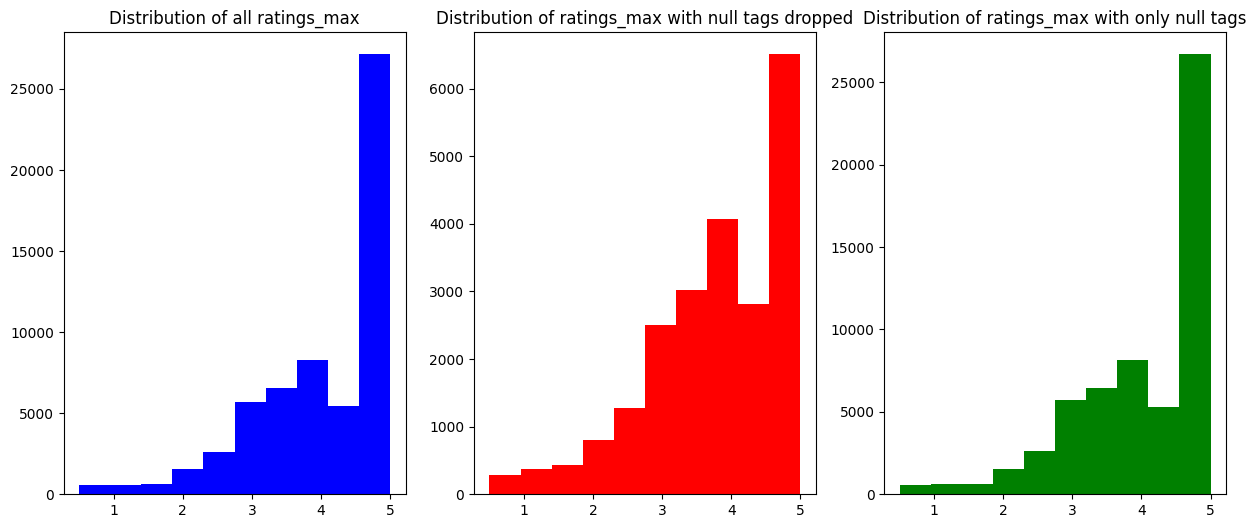

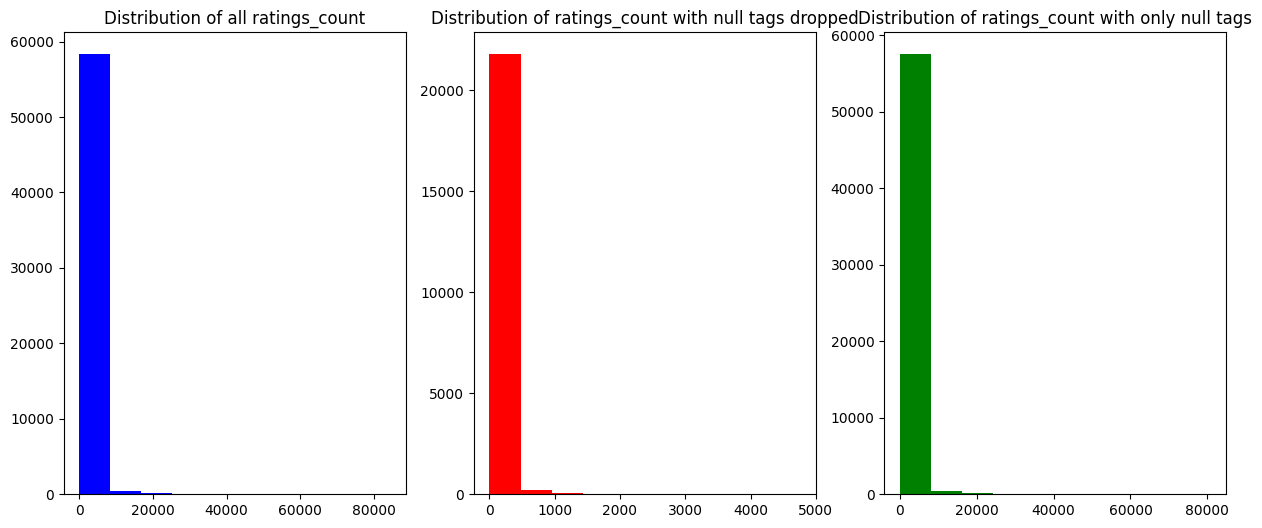

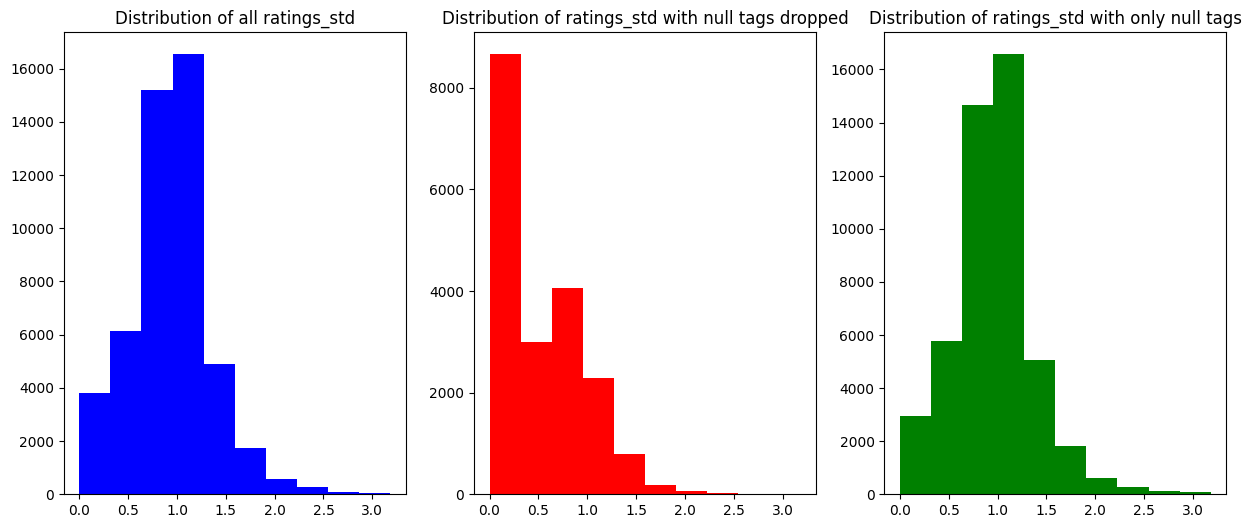

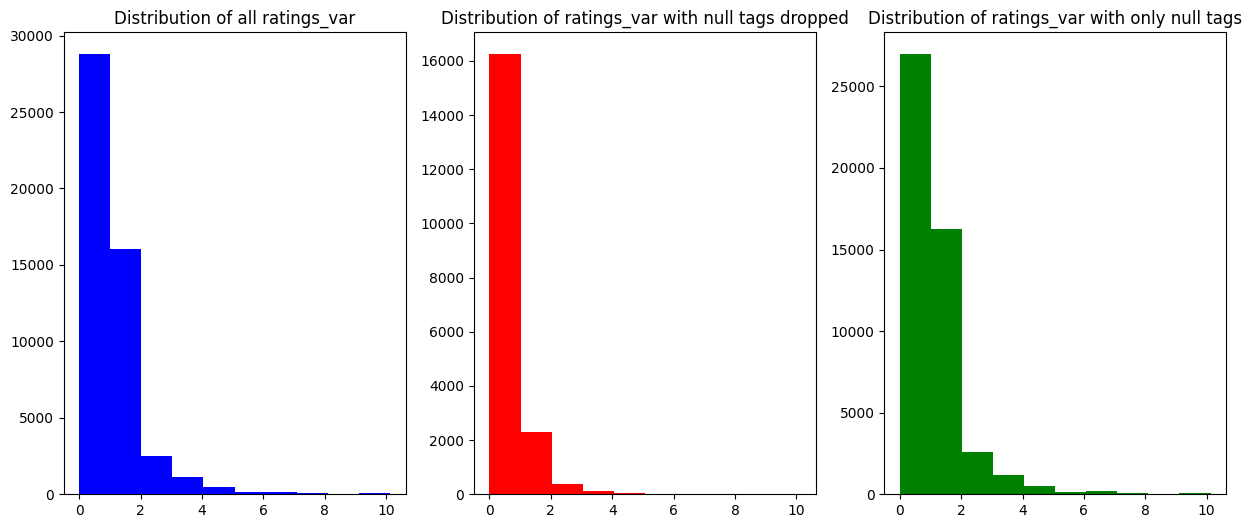

In [16]:
for col in all_cols:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 6))
    null = movies_stats_all[col]
    nonull = movies_stats_nonull[col]
    onlynull = movies_stats_onlynull[col]
    ax1.hist(null, color='blue')
    ax1.set_title(f'Distribution of all {col}')

    ax2.hist(nonull, color='red')
    ax2.set_title(f'Distribution of {col} with null tags dropped')

    ax3.hist(onlynull, color='green')
    ax3.set_title(f'Distribution of {col} with only null tags')

In [17]:
print(movies_stats_all['ratings_mean'].mean())
print(movies_stats_nonull['ratings_mean'].mean())
print(movies_stats_onlynull['ratings_mean'].mean())

3.0777039038524
3.344562766908376
3.0670977946438174


We can see that the dataset that includes ONLY null tags is large and represents the majority of the dataset. Each distribution of the only null data statistics looks pretty much the same as the dataset with all instances. Because of the large amount of instances without tags, we would predict that removing these instances would affect the distributions above. While thankfully some distributions look very similar—including variation, standard deviation, mean, count, and q75—some look VERY different. The minimum statistic is included in this.

While the minimum is still between 1 and 5, the highest occurence of min is about 3 for the null tag dropped dataset while the other datasets have a much greater occurence of 1 for min. So, we can assume that many movies with just one rating did not have tags and therefore were dropped. From this, we can also make the assumption that the more popular a movie is (the more ratings it has), the more likely it is to have a tag included. We could also assume that if the non-null dataset includes more popular movies, then the overall mean is higher in the non-null dataset. This assumption is true. The dataset with null tags dropped has a mean rating statistic of 3.3 while the other two datasets have a mean rating statistic of 3.1.

We need to keep in mind when we discuss our results that the dataset we are using has more popular and highly rated movies than the overall dataset. There can be two effects in our binary classification:
    1. This may skew our binary classification to predict a movie is 'good' (above the overall mean) because there are more instances with high ratings values.
    2. This may skew our binary classification to predict a movie is 'bad' (below the overall mean) because the overall mean for a movie is higher due to more positive ratings.

However, if the movies that were dropped are most likely to only have one rating, then binary classification would be obsolete because the mean would be the same as the instance.

Overall, it is important in the overall statistics to remember that many of the dropped movies had one rating. We will investigate further how dropping these movies affect our results.

### 🔷 Merging Ratings with Movies

Finally, we want to merge our ratings dataset (that has null tags dropped) with the movies dataset. We want each instance of movieID to also include movie title and movie genres. We will merge on the ratings dataset so that we retain each instance of rating and just add the movie data to each rating instance. The resulting dataset will have the same shape as the ratings dataset with null tags dropped.

We also will drop the timestamp column from ratings. We will not be doing any sort of time series analysis, so this column is obsolete to our classification.

In [18]:
ratings_non_null_tags = ratings_and_tags.dropna()
ml_dataset = pd.merge(ratings_non_null_tags, movies_df, on='movieId', how='left')
ml_dataset.drop(columns=['timestamp_x', 'timestamp_y'], inplace=True)
ml_dataset.head()

,userId,movieId,rating,tag,title,genres
0,3,260,4.0,classic,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
1,3,260,4.0,sci-fi,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
2,4,1732,4.5,dark comedy,"Big Lebowski, The (1998)",Comedy|Crime
3,4,1732,4.5,great dialogue,"Big Lebowski, The (1998)",Comedy|Crime
4,4,7569,3.5,so bad it's good,You Only Live Twice (1967),Action|Adventure|Sci-Fi|Thriller


### Null Value Check

In [19]:
ml_dataset.isna().sum()

userId     0
movieId    0
rating     0
tag        0
title      0
genres     0
dtype: int64

## Encoding Labels

For many of our models we are using, we need to encode our labels from strings to numbers. We can use the scikit learn LabelEncoder for this. The columns that need to be encoded include tag, title, and genres.

In [20]:
labels_to_encode = ['tag', 'title', 'genres']
labelencoder = LabelEncoder()
for label in labels_to_encode:
    try:
        ml_dataset[label] = labelencoder.fit_transform(ml_dataset[label])
    except:
        pass

In [21]:
ml_dataset.head()

,userId,movieId,rating,tag,title,genres
0,3,260,4.0,29700,17200,158
1,3,260,4.0,49485,17200,158
2,4,1732,4.5,31423,2286,844
3,4,1732,4.5,36815,2286,844
4,4,7569,3.5,51295,21873,160


## Enumerating Ratings

Now, we want to assign each rating a number: 0 if the rating is less than the mean value for that movie OR 1 if the ratings is greater than or equal to the mean value for that movie.

We will group the ratings by movie, calculate the mean rating for each movie, and add a new column 'movie_rating_mean' to each rating instance. Then, we can go through each rating instance and enumerate its rating based on the movie_rating_mean column.

In [22]:
# Get mean rating of each movie
movie_means = ml_dataset.groupby('movieId')['rating'].agg(['mean'])
# Round to 1 decimal to match existing ratings
movie_means['mean'] = movie_means['mean'].round(1)
# Change name of mean column
movie_means = movie_means.rename(columns={'mean': 'movie_rating_mean'}).reset_index()

In [23]:
# Add means to ml_dataset on movieId
ml_dataset = pd.merge(ml_dataset, movie_means, on='movieId', how='left')
ml_dataset.head()

,userId,movieId,rating,tag,title,genres,movie_rating_mean
0,3,260,4.0,29700,17200,158,4.2
1,3,260,4.0,49485,17200,158,4.2
2,4,1732,4.5,31423,2286,844,4.3
3,4,1732,4.5,36815,2286,844,4.3
4,4,7569,3.5,51295,21873,160,3.7


In [24]:
# Add enumerated rating for each row
ml_dataset['rating_enum'] = np.where(ml_dataset['rating'] < ml_dataset['movie_rating_mean'], 0, 1)
ml_dataset

,userId,movieId,rating,tag,title,genres,movie_rating_mean,rating_enum
0,3,260,4.0,29700,17200,158,4.2,0
1,3,260,4.0,49485,17200,158,4.2,0
2,4,1732,4.5,31423,2286,844,4.3,1
3,4,1732,4.5,36815,2286,844,4.3,1
4,4,7569,3.5,51295,21873,160,3.7,0
...,...,...,...,...,...,...,...,...
834725,162521,66934,4.5,15210,5490,908,4.4,1
834726,162521,103341,4.5,30644,21733,283,3.6,1
834727,162534,189169,2.5,30120,20468,843,2.5,1
834728,162534,189169,2.5,32166,20468,843,2.5,1


### Let's look at the distribution of 'good' and 'bad' ratings.

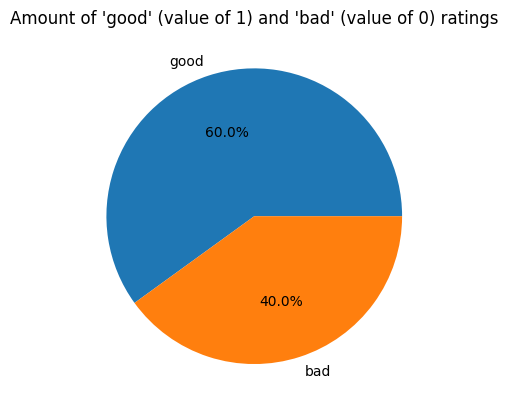

In [25]:
labels = ['good', 'bad']
sizes = ml_dataset['rating_enum'].value_counts()
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title("Amount of 'good' (value of 1) and 'bad' (value of 0) ratings")
plt.show()

Our dataset is now combined, cleaned, and ready for analysis.

<Axes: >

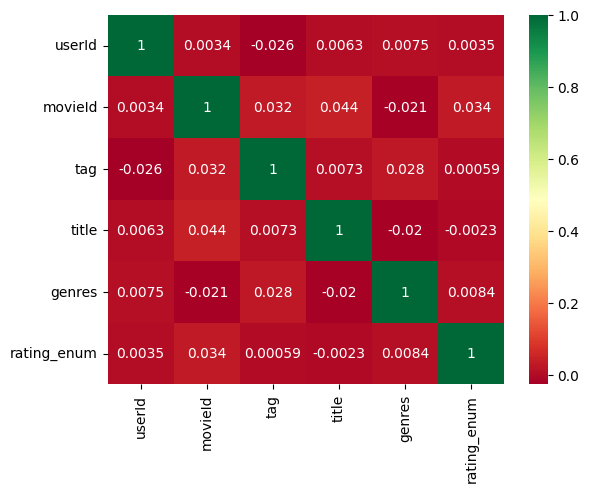

In [26]:
sns.heatmap(ml_dataset.drop(columns=['rating', 'movie_rating_mean']).corr(), annot=True, cmap="RdYlGn")

## Splitting the Data

We will split our data in two ways:

1. Training, testing, and validation splits. We are splitting into these three categories because we are running multiple models. For each model, we will run the testing dataset to test as we perform hyperparameter tuning. Once all models are done, we will run each one with the validation data. This way, we are fairly analyzing each model and making sure the hyperparameter tuning is not showing scores that are overfit to the testing data.
2. X and Y splits. We will isolate our target, which is the rating_enum column, and our descriptive data. We will not include the rating and movie_rating_mean columns as they were just placeholders to calculate our rating_enum column.

In [27]:
# Assign the target and features
TARGET = ['rating_enum']
TO_DROP = ['rating_enum', 'rating', 'movie_rating_mean']
X, y = ml_dataset.drop(columns=TO_DROP, axis=1), ml_dataset[TARGET]

In [30]:
# Split your data into training and temporary data (used for individual testing)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Split the temporary data into testing and validation data (for final tests)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

- The train_test_split() function from scikit-learn is used to split the data into training and temporary sets.
- test_size=0.3 specifies that 30% of the data should be allocated to the temporary set, while the remaining 70% goes to the training set.
- X_temp and y_temp are passed as input, representing the features and target variable from the temporary set.
- test_size=0.5 specifies that the temporary set should be divided equally into testing and validation sets, each with 50% of the data.



### Using Gaussian Naive Bayes Classifier

Implementation using no hyperparameter tuning

We Import the GaussianNB class from scikit-learn and then create an instance of the GaussianNB model

In [ ]:
# Import GaussianNB from scikit-learn
from sklearn.naive_bayes import GaussianNB

# Instantiate GNB model
gnb_no_tune = GaussianNB()

# Fit GNB model to training data
gnb_no_tune.fit(X_train, y_train)

GaussianNB()

We will be using the trained GNB model to make predictions on the testing set

In [ ]:
# Make predictions on testing data
y_pred = gnb_no_tune.predict(X_test)

# Evaluate model performance using accuracy, precision, recall, and F1-score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

no_tune_accuracy = accuracy_score(y_test, y_pred)
no_tune_precision = precision_score(y_test, y_pred)
no_tune_recall = recall_score(y_test, y_pred)
no_tune_f1 = f1_score(y_test, y_pred)

print("Accuracy:", no_tune_accuracy)
print("Precision:", no_tune_precision)
print("Recall:", no_tune_recall)
print("F1-score:", no_tune_f1)

Accuracy: 0.5993099537573178
Precision: 0.5993099537573178
Recall: 1.0
F1-score: 0.7494606687707243


In [ ]:
# Import confusion_matrix from scikit-learn
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
print(cm)

In [ ]:
#Classification Report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

In [ ]:
# Create heatmap using Seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

## Hyperparameter Tuning

- A hyperparameter grid with different values for the var_smoothing parameter is defined, which controls the additive smoothing applied to variances during probability estimation.
- The GridSearchCV object is created using the GNB model, hyperparameter grid, and 'accuracy' as the evaluation metric.
- The cv=5 parameter specifies 5-fold cross-validation for more robust evaluation.

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {'var_smoothing': [1e-9, 1e-8, 1e-7]}

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid, scoring='accuracy', cv=5)

# Perform hyperparameter tuning
grid_search.fit(X_train, y_train)

# Get best hyperparameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best hyperparameters:", best_params)
print("Best model accuracy on training set:", best_model.score(X_train, y_train))


In [ ]:
print("No Tune Accuracy: ", no_tune_accuracy)
print("After Tune Accuracy", best_model.score(X_train, y_train))

print("Change in Accuracy: ", best_model.score(X_train, y_train) - no_tune_accuracy)

In [ ]:
after_tune_accuracy = best_model.score(X_train, y_train)

Comparing the model accuraccies before and after hyperparameter tuning

In [ ]:
# Prepare accuracy data
accuracies = [no_tune_accuracy, after_tune_accuracy]
labels = ['Original Model', 'Tuned Model']

# Create bar chart
plt.bar(labels, accuracies)
plt.title('Model Accuracies')
plt.ylabel('Accuracy')

# Set y-axis limits to focus on the range of accuracies
plt.ylim(min(accuracies) - 0.0001, max(accuracies) + 0.001)

plt.show()

## Neural Network

- A sequential neural network is defined with two hidden layers of 64 and 32 neurons, respectively, and an output layer with a single neuron for binary classification.
- The relu activation function is used for the hidden layers, and the sigmoid activation function is used for the output layer.
- The model is compiled using the Adam optimizer, binary cross-entropy loss, and accuracy as the evaluation metric.
- The model is trained for 10 epochs with a batch size of 32.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Define the neural network model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model on the training set
model.fit(X_train, y_train, epochs=5, batch_size=32)

# Evaluate the model on the testing set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test accuracy:", test_accuracy)

The model's performace is evaluated using various metrics and plots of the learning curves for both accuracy and loss are generated.

In [ ]:
# Evaluate model performance
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

In [ ]:
# Analyze confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
print(cm)

In [ ]:
# Examine learning curves
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

## Random Forest

First fitting on default settings

In [ ]:
FOREST = RandomForestClassifier()
FOREST.fit(X_train, y_train)

y_pred = FOREST.predict(X_test)

Accuracy: 0.84
Confusion Matrix:
[[36941 13229]
 [ 6591 68448]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.74      0.79     50170
           1       0.84      0.91      0.87     75039

    accuracy                           0.84    125209
   macro avg       0.84      0.82      0.83    125209
weighted avg       0.84      0.84      0.84    125209



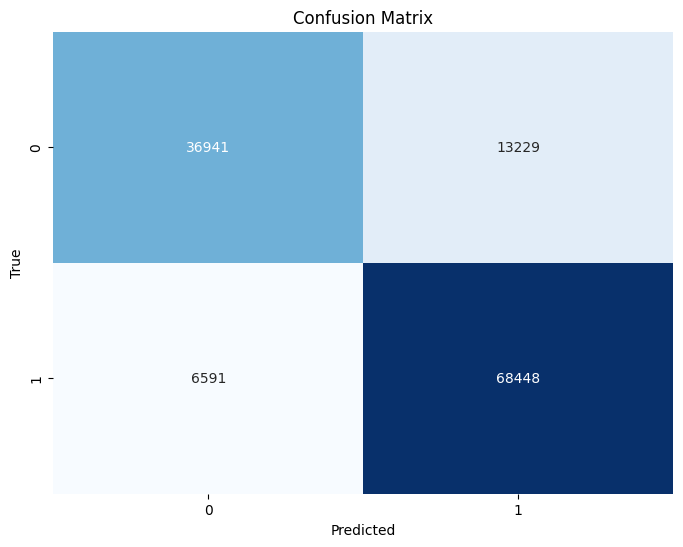

In [ ]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
confusion = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:")
print(confusion)
print("Classification Report:")
print(class_report)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=FOREST.classes_, yticklabels=FOREST.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#### Random Forest Grid Search Hyper parameter tuning

In [ ]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [20, 30],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=2, scoring='accuracy', n_jobs=-1)

# Assuming you have your data and target variables as X and y, fit the grid search
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_
print("Best Hyperparameters: ", best_params)
print("Best Accuracy: ", best_accuracy)

Best Hyperparameters:  {'bootstrap': False, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best Accuracy:  0.7912310342565525


#### XGBoost

In [28]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [31]:
xgb_model = XGBClassifier();
xgb_model.fit(X_train, y_train);

Accuracy: 0.68
Confusion Matrix:
[[18186 31984]
 [ 7503 67536]]
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.36      0.48     50170
           1       0.68      0.90      0.77     75039

    accuracy                           0.68    125209
   macro avg       0.69      0.63      0.63    125209
weighted avg       0.69      0.68      0.66    125209



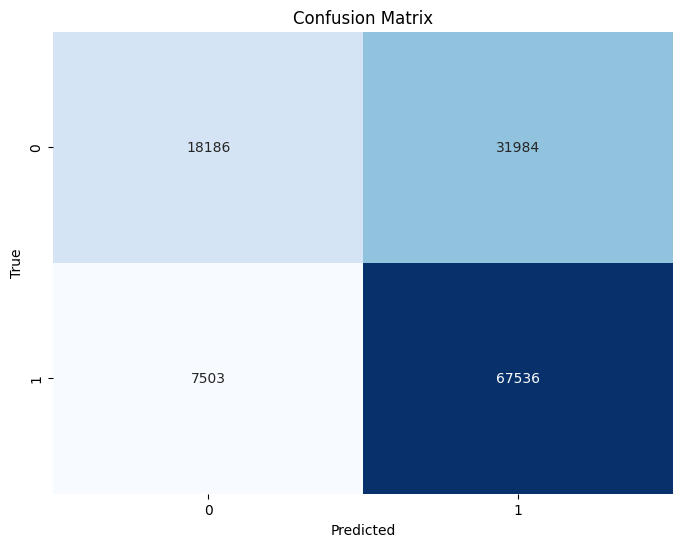

In [32]:
y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
confusion = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:")
print(confusion)
print("Classification Report:")
print(class_report)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=xgb_model.classes_, yticklabels=xgb_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

##### XGBoost Grid Search

In [33]:
param_grid = {
    'learning_rate': [0.01, 0.2],
    'n_estimators': [50, 200],
    'max_depth': [3, 4],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

# Step 5: Perform grid search with cross-validation
grid_search = GridSearchCV(xgb_model, param_grid, scoring='accuracy', cv=3)
grid_search.fit(X_train, y_train)

# Step 6: Get the best parameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

In [36]:
print(best_params)

{'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 200, 'subsample': 1.0}


Accuracy: 0.66
Confusion Matrix:
[[14893 35277]
 [ 7460 67579]]
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.30      0.41     50170
           1       0.66      0.90      0.76     75039

    accuracy                           0.66    125209
   macro avg       0.66      0.60      0.59    125209
weighted avg       0.66      0.66      0.62    125209



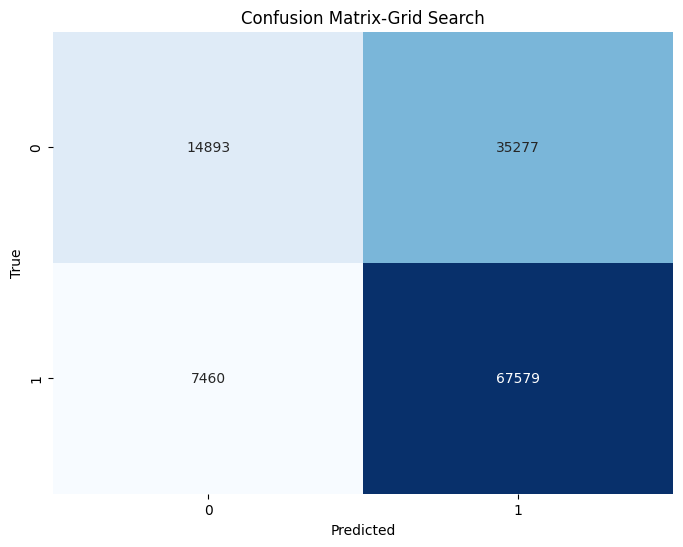

In [35]:
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
confusion = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:")
print(confusion)
print("Classification Report:")
print(class_report)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix-Grid Search')
plt.show()